In [1]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz

In [3]:
from scipy.signal import savgol_filter

from common import combine_csvs

In [37]:
DOWN = '*down.csv'
UP = '*up.csv'
N_TYPE = 'Type'
N_REGIONS = 'region'
N_TIMESTAMP = 'timestamp'
N_TRANSF_TIME = 'Transfer Time (s)'
N_DATA_SIZES = 'Data Sizes'

In [6]:
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sns.set_context("paper", rc={"font.size":9,"axes.titlesize":9,"axes.labelsize":8, "xtick.labelsize":8})

In [7]:
def concat_df(src, pattern):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    convert_to_mb(combined_df)
    return combined_df

In [8]:
def combine_reg(src, pattern, keep='bandwidth'):
    regions_df = pd.DataFrame()
    start = True
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, [keep]).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df.rename(columns={keep: reg_name}, inplace=True)

        if start:
            regions_df = combined_df
            start = False
        else:
            regions_df = pd.merge(regions_df, combined_df, how='outer', left_index=True, right_index=True)

    return regions_df

In [11]:
from ipyfilechooser import FileChooser

# Create and display a FileChooser widget
fc = FileChooser('data/Home_network_data/SCP/')
fc.sandbox_path = 'data/Home_network_data/SCP/'
display(fc)

FileChooser(path='/home/sami/starlink-plot/data/Home_network_data/SCP', filename='', title='', show_hidden=Fal…

In [12]:
fc1 = FileChooser('data/starlink-data/SCP/')
fc1.sandbox_path = 'data/starlink-data/SCP/'
display(fc1)

FileChooser(path='/home/sami/starlink-plot/data/starlink-data/SCP', filename='', title='', show_hidden=False, …

In [21]:
#src_dirs = [('Starlink', 'data/Starlink_csv_2022_04-07_to_04-12/')]
#src_dirs = [('Home', 'data/Home_network_data/Iperf_csv/2022-01-19_trad_iperf/')]
src_dirs = []
if fc1.selected_path:
    src_dirs.append(('Starlink', fc1.selected_path))
if fc.selected_path:
    src_dirs.append(('Home', fc.selected_path))
src_dirs

[('Starlink',
  '/home/sami/starlink-plot/data/starlink-data/SCP/2022-06-06_starlink_measures_scp')]

In [53]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    files = glob.glob(f"{folder}/**/{DOWN}", recursive=True)
    df_temp = pd.concat([pd.read_csv(f) for f in files])
    df_temp.timestamp = pd.to_datetime(df_temp.timestamp, unit='s')
    
    df_temp[N_TYPE] = type_name
    if not df.empty:
        df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
    else:
        df = df_temp
df.dropna(how='all', inplace=True)
df

,timestamp,region,1MB,10MB,100MB,200MB,300MB,Type
0,2022-06-06 14:18:20,sa-east-1,4.872,6.451,58.193,30.542,103.675,Starlink
1,2022-06-06 17:41:14,sa-east-1,5.267,18.876,17.465,32.072,69.107,Starlink
2,2022-06-06 21:38:09,sa-east-1,5.261,5.939,17.086,30.399,59.845,Starlink
3,2022-06-07 01:45:05,sa-east-1,5.187,19.880,17.177,158.127,403.818,Starlink
4,2022-06-07 06:29:19,sa-east-1,5.099,6.411,26.132,45.788,216.885,Starlink
...,...,...,...,...,...,...,...,...
15,2022-06-09 01:28:30,ap-south-1,6.925,16.201,23.231,113.213,92.896,Starlink
16,2022-06-09 05:48:07,ap-south-1,6.368,13.967,55.836,65.630,79.061,Starlink
17,2022-06-09 09:38:45,ap-south-1,7.884,16.013,34.532,48.712,79.561,Starlink
18,2022-06-09 13:50:51,ap-south-1,6.966,12.485,24.526,73.309,114.379,Starlink


In [65]:
# Aggreagation options
df_regs_interp = df_regs
df_regs_interp = df_regs_interp.resample('H').mean()
df_regs_interp = df_regs_interp.interpolate(method='linear')
df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


Starlink                         \
                    South_America_Sao_Paulo Asia_Pacific_Singapore   
timestamp                                                            
2022-01-23 05:00:00                     NaN                    NaN   
2022-01-23 06:00:00                     NaN                    NaN   
2022-01-23 07:00:00                     NaN                    NaN   
2022-01-23 08:00:00                     NaN                    NaN   
2022-01-23 09:00:00                     NaN                    NaN   
...                                     ...                    ...   
2022-02-19 18:00:00              105.100351             109.955001   
2022-02-19 19:00:00              104.457675             108.875664   
2022-02-19 20:00:00              103.814998             107.796326   
2022-02-19 21:00:00              103.172322             106.716989   
2022-02-19 22:00:00              102.529646             105.637652   

                                                              \
                    Asia_Pacific_Sydney US_West_N_California   
timestamp                                                      
2022-01-23 05:00:00           16.670687                  NaN   
2022-01-23 06:00:00           18.322454                  NaN   
2022-01-23 07:00:00           19.974221                  NaN   
2022-01-23 08:00:00           21.625988                  NaN   
2022-01-23 09:00:00           23.277755                  NaN   
...                                 ...                  ...   
2022-02-19 18:00:00          125.603151           170.688804   
2022-02-19 19:00:00          125.603151           170.669147   
2022-02-19 20:00:00          125.603151           170.649490   
2022-02-19 21:00:00          125.603151           170.629833   
2022-02-19 22:00:00          125.603151           170.610176   

                                                                          \
                    Middle_East_Bahrain Asia_Pacific_Tokyo Europe_London   
timestamp                                                                  
2022-01-23 05:00:00                 NaN                NaN           NaN   
2022-01-23 06:00:00                 NaN                NaN           NaN   
2022-01-23 07:00:00                 NaN                NaN           NaN   
2022-01-23 08:00:00                 NaN                NaN           NaN   
2022-01-23 09:00:00                 NaN                NaN           NaN   
...                                 ...                ...           ...   
2022-02-19 18:00:00          102.937528         100.712472    120.206664   
2022-02-19 19:00:00          102.574452          99.076515    120.195073   
2022-02-19 20:00:00          102.211375          97.440558    120.183481   
2022-02-19 21:00:00          101.848299          95.804601    120.171890   
2022-02-19 22:00:00          101.485222          94.168644    120.160299   

                                         
                    Asia_Pacific_Mumbai  
timestamp                                
2022-01-23 05:00:00                 NaN  
2022-01-23 06:00:00                 NaN  
2022-01-23 07:00:00                 NaN  
2022-01-23 08:00:00                 NaN  
2022-01-23 09:00:00                 NaN  
...                                 ...  
2022-02-19 18:00:00           72.534242  
2022-02-19 19:00:00           71.623609  
2022-02-19 20:00:00           70.712976  
2022-02-19 21:00:00           69.802342  
2022-02-19 22:00:00           68.891709  

[666 rows x 8 columns]

In [54]:
df_unstacked = df.melt(id_vars=[N_REGIONS, N_TYPE, N_TIMESTAMP], value_vars=['1MB', '10MB', '100MB', '200MB', '300MB'],
                      var_name=N_DATA_SIZES, value_name=N_TRANSF_TIME)
df_unstacked

,region,Type,timestamp,Data Sizes,Transfer Time (s)
0,sa-east-1,Starlink,2022-06-06 14:18:20,1MB,4.872
1,sa-east-1,Starlink,2022-06-06 17:41:14,1MB,5.267
2,sa-east-1,Starlink,2022-06-06 21:38:09,1MB,5.261
3,sa-east-1,Starlink,2022-06-07 01:45:05,1MB,5.187
4,sa-east-1,Starlink,2022-06-07 06:29:19,1MB,5.099
...,...,...,...,...,...
895,ap-south-1,Starlink,2022-06-09 01:28:30,300MB,92.896
896,ap-south-1,Starlink,2022-06-09 05:48:07,300MB,79.061
897,ap-south-1,Starlink,2022-06-09 09:38:45,300MB,79.561
898,ap-south-1,Starlink,2022-06-09 13:50:51,300MB,114.379


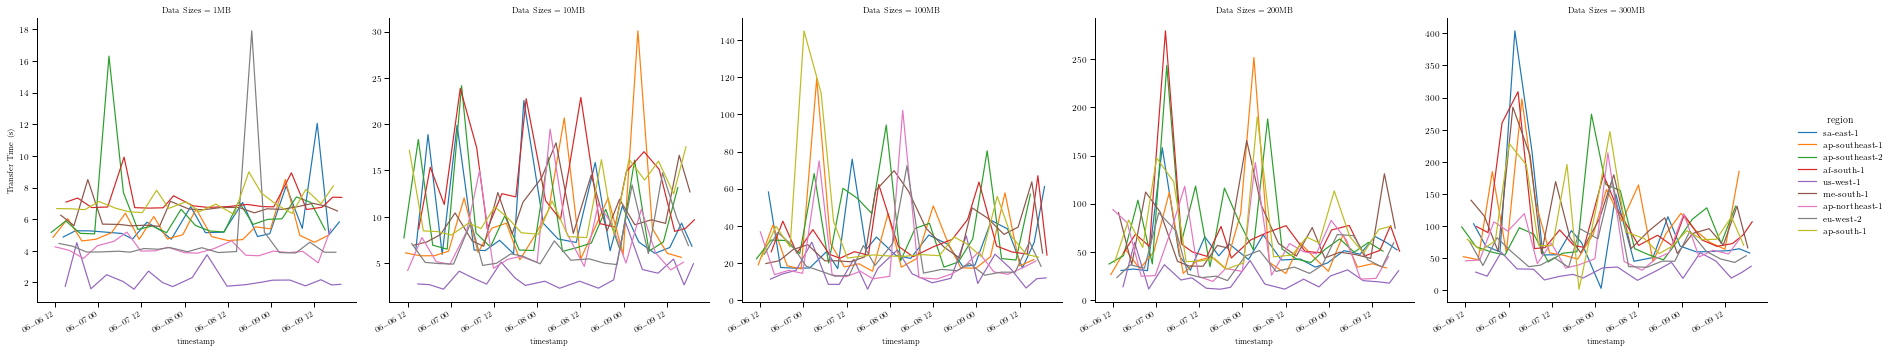

In [63]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

#g = sns.lineplot(data=df_unstacked, x=N_TIMESTAMP, y=N_TRANSF_TIME, hue=N_REGIONS, style=N_DATA_SIZES)
g = sns.FacetGrid(data=df_unstacked, col=N_DATA_SIZES, hue=N_REGIONS, sharey=False, height=5)
g.map(sns.lineplot, N_TIMESTAMP, N_TRANSF_TIME)
#g = sfigurelineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')
g.figure.autofmt_xdate()
g.add_legend()
g.tight_layout()

#fig.tight_layout()

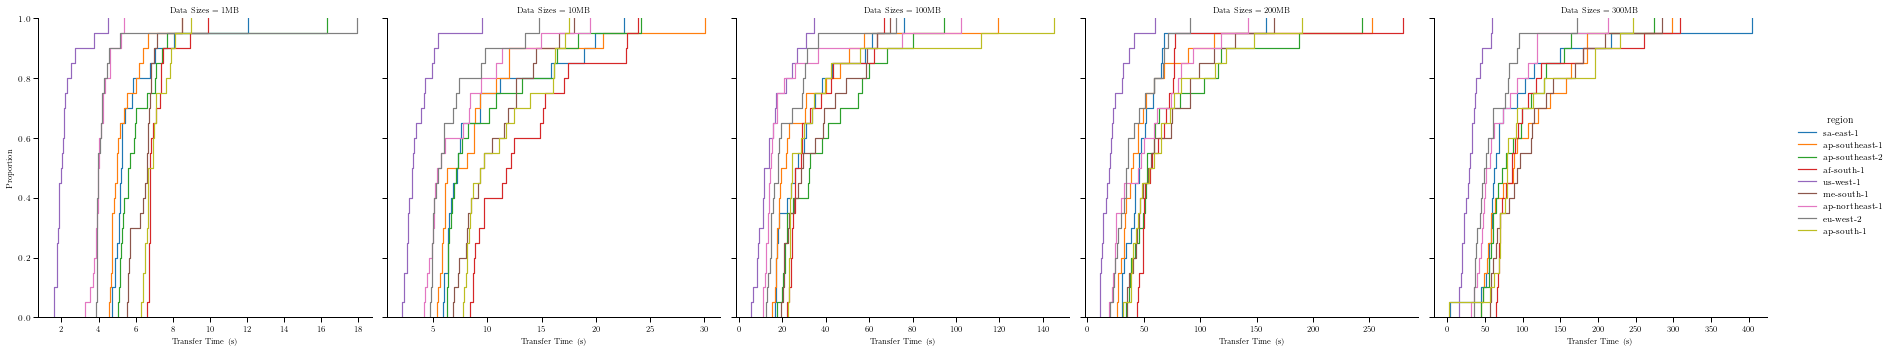

In [64]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, col=N_DATA_SIZES, hue=N_REGIONS, sharex=False, height=5)
g2.map(sns.ecdfplot, N_TRANSF_TIME)
g2.add_legend()
#sns.ecdfplot(data=df_unstacked, x='bandwidth', hue=N_REGIONS)
g2.tight_layout()
#fig2.tight_layout()

In [65]:
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')
g.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')